In [1]:
from google.colab import drive
drive.mount('/gdrive')
# %cd /gdrive/My Drive/Alzheimer_Project

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/Alzheimers-Disease-Detection

/gdrive/MyDrive/Alzheimers-Disease-Detection


In [3]:
%ls

AD_Inception_V3.ipynb                   Inception_V3_ROC.png
AD_Inception_V3_old.ipynb               README.md
AD_Model_Inception_V3.h5                test/
AD_Model_VGG19.h5                       train/
AD_VGG19.ipynb                          VGG19_accuracy.png
AD_VGG19_old.ipynb                      VGG19_Classification_Report.png
Inception_V3_accuracy.png               VGG19_Confusion_Matrix.png
Inception_V3_Classification_Report.png  VGG19_loss.png
Inception_V3_Confusion_Matrix.png       VGG19_ROC.png
Inception_V3_loss.png                   Weights_AD_Model_VGG19.hdf5


Importing Libraries

In [4]:
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [5]:
IMAGE_SIZE = [229,229]

epochs = 500
batch_size = 64

IMAGE DATA PREPROCESSING

In [6]:
dement_path = '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/MildDemented'
nondement_path = '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/NonDemented'

NonDemfiles = glob( nondement_path +'/*' )
Demfiles = glob( dement_path + '/*' )

In [7]:
print("First 5 NonDem Files: ",NonDemfiles[0:5])
print("Total Count: ",len(NonDemfiles))
print("First 5 MildDem Files: ",Demfiles[0:5])
print("Total Count: ",len(Demfiles))

First 5 NonDem Files:  ['/gdrive/MyDrive/Alzheimers-Disease-Detection/train/NonDemented/nonDem10.jpg', '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/NonDemented/nonDem11.jpg', '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/NonDemented/nonDem107.jpg', '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/NonDemented/nonDem111.jpg', '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/NonDemented/nonDem0.jpg']
Total Count:  500
First 5 MildDem Files:  ['/gdrive/MyDrive/Alzheimers-Disease-Detection/train/MildDemented/mildDem1.jpg', '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/MildDemented/mildDem0.jpg', '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/MildDemented/mildDem100.jpg', '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/MildDemented/mildDem10.jpg', '/gdrive/MyDrive/Alzheimers-Disease-Detection/train/MildDemented/mildDem106.jpg']
Total Count:  500


In [8]:
Dem_labels = []
NonDem_labels = []

Dem_images=[]
NonDem_images=[]

for i in range(len(Demfiles)):
  image = cv2.imread(Demfiles[i]) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image,(229,229)) 
  Dem_images.append(image) 
  Dem_labels.append('Demented') 
for i in range(len(NonDemfiles)):
  image = cv2.imread(NonDemfiles[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(229,229))
  NonDem_images.append(image)
  NonDem_labels.append('NonDemented')

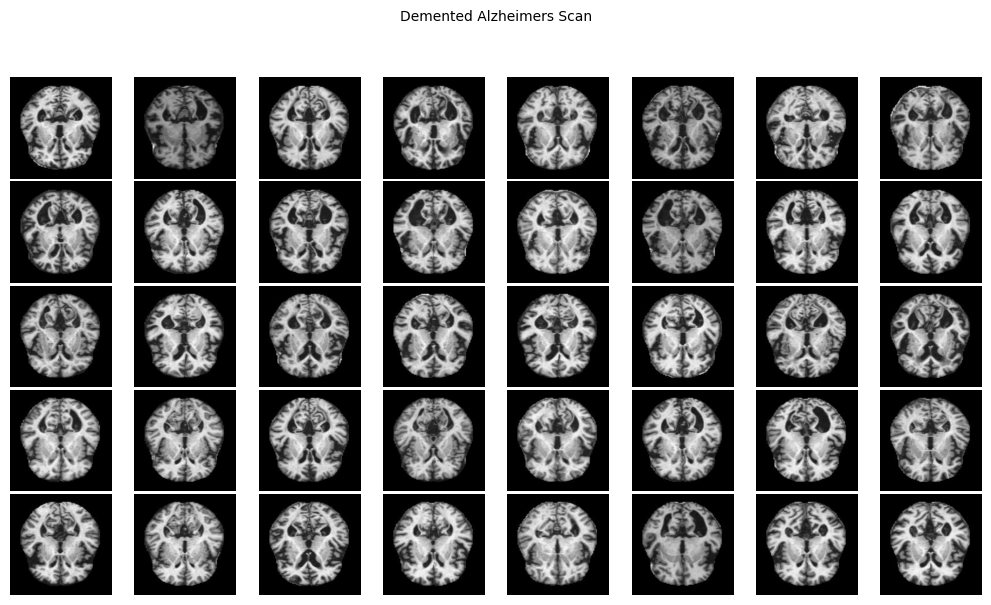

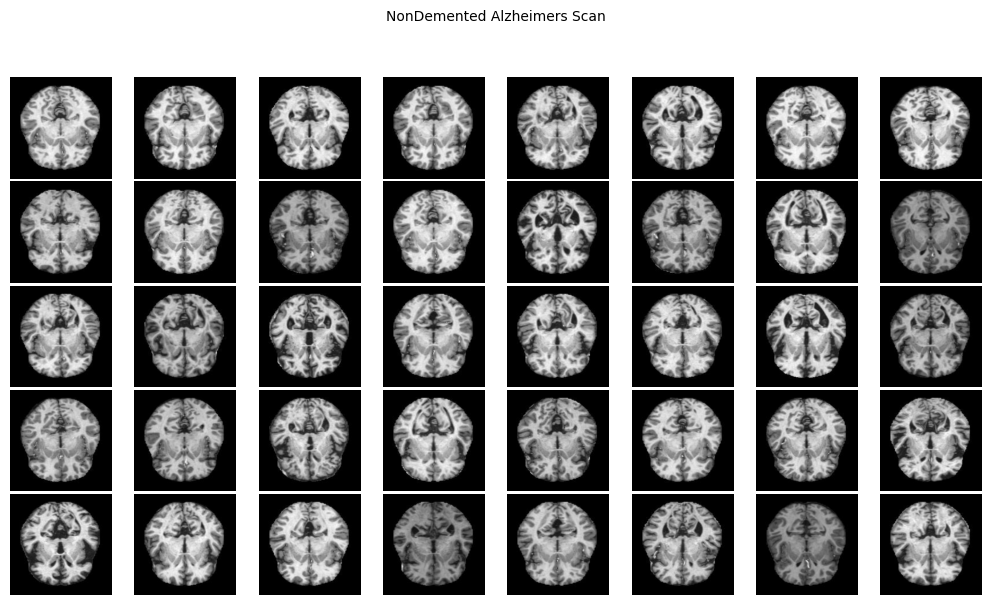

In [10]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=10)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(Dem_images, 'Demented Alzheimers Scan')
plot_images(NonDem_images, 'NonDemented Alzheimers Scan')

In [11]:
Dem_images = np.array(Dem_images) / 255
NonDem_images = np.array(NonDem_images) / 255

In [12]:
Dem_x_train, Dem_x_test, Dem_y_train, Dem_y_test = train_test_split(
    Dem_images, Dem_labels, test_size=0.2)
NonDem_x_train, NonDem_x_test, NonDem_y_train, NonDem_y_test = train_test_split(
    NonDem_images, NonDem_labels, test_size=0.2)


X_train = np.concatenate((NonDem_x_train, Dem_x_train), axis=0)
X_test = np.concatenate((NonDem_x_test, Dem_x_test), axis=0)
y_train = np.concatenate((NonDem_y_train, Dem_y_train), axis=0)
y_test = np.concatenate((NonDem_y_test, Dem_y_test), axis=0)

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

**Building and Visualizing InceptionV3 Model**

In [13]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(229, 229, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.4)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87910968/87910968 [==============================] - 3s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 114, 114, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 114, 114, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# **Image Augmentation**

Training images at various angles, flips,positions etc.

In [15]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

**Training the Model**

In [16]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
12/12 [==============================] - 29s 1s/step - loss: 7.1919 - accuracy: 0.5738 - val_loss: 3.9877 - val_accuracy: 0.7600
Epoch 2/500
12/12 [==============================] - 11s 919ms/step - loss: 2.3440 - accuracy: 0.7800 - val_loss: 2.4009 - val_accuracy: 0.8200
Epoch 3/500
12/12 [==============================] - 11s 852ms/step - loss: 1.2753 - accuracy: 0.8363 - val_loss: 1.3197 - val_accuracy: 0.8300
Epoch 4/500
12/12 [==============================] - 11s 876ms/step - loss: 1.2211 - accuracy: 0.8388 - val_loss: 0.5739 - val_accuracy: 0.8850
Epoch 5/500
12/12 [==============================] - 11s 891ms/step - loss: 0.9009 - accuracy: 0.8413 - val_loss: 0.7149 - val_accuracy: 0.8800
Epoch 6/500
12/12 [==============================] - 10s 764ms/step - loss: 0.9771 - accuracy: 0.8200 - val_loss: 0.4306 - val_accuracy: 0.8850
Epoch 7/500
12/12 [==============================] - 11s 847ms/step - loss: 0.7220 - accuracy: 0.8550 - val_loss: 0.3967 - val_accuracy: 0.

In [17]:
model.save('AD_Model_Inception_V3.h5')
model.save_weights('Weights_AD_Model_Inception_V3.hdf5')

**Predicting trained model on test set**

In [18]:
model = load_model('AD_Model_Inception_V3.h5')

In [19]:
y_pred = model.predict(X_test, batch_size=batch_size)

4/4 [==============================] - 2s 149ms/step


**Visualizing predicted classes**

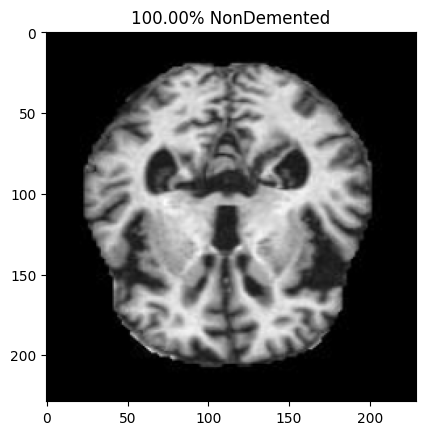

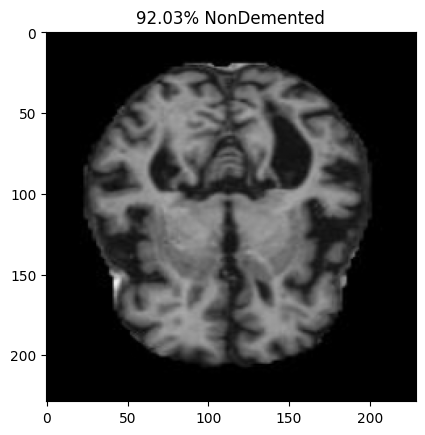

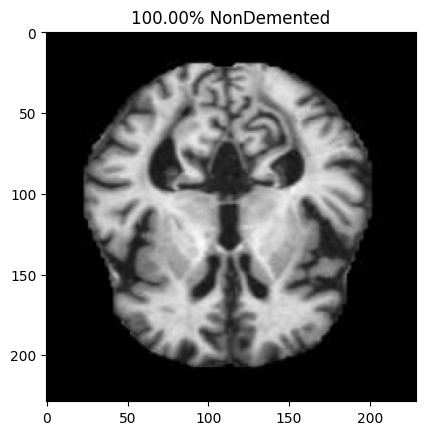

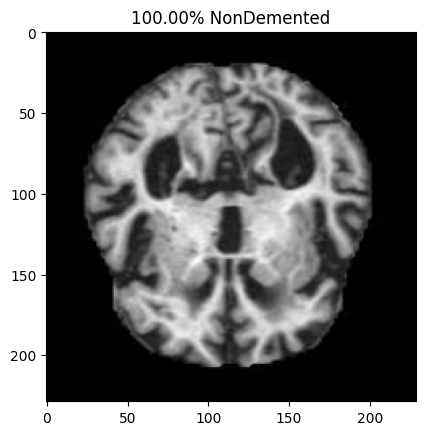

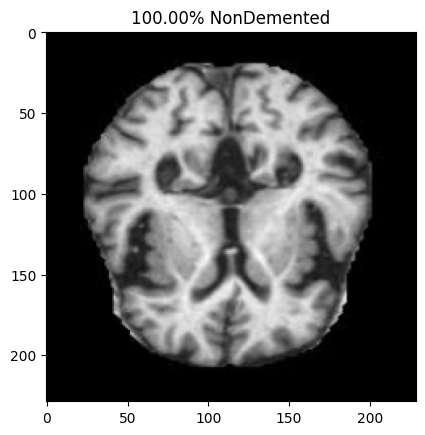

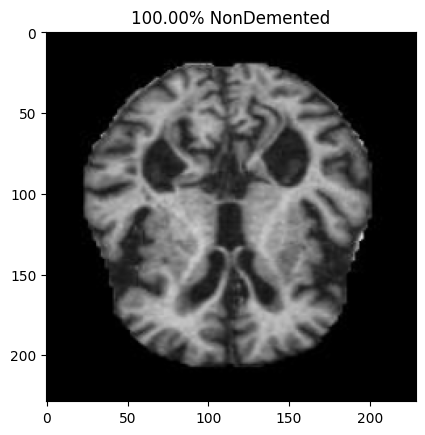

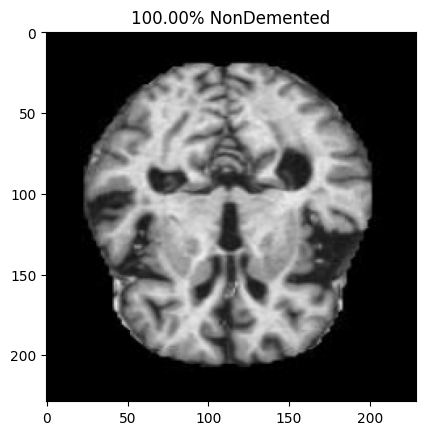

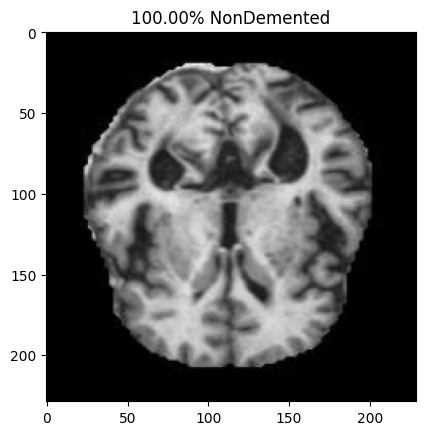

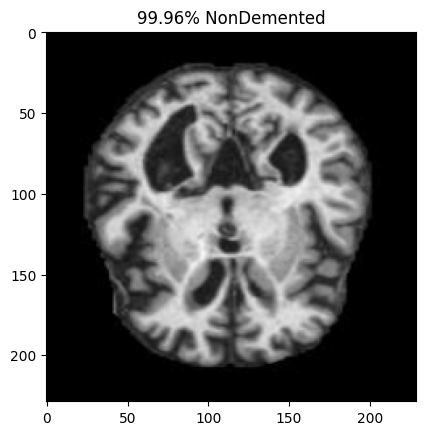

In [20]:
prediction=y_pred[1:10]
for index, probability in enumerate(prediction):
  if probability.item(0) > 0.5:
        plt.title('%.2f' % (probability.item(0)*100) + '% Demented')
  else:
        plt.title('%.2f' % ((1-probability.item(0))*100) + '% NonDemented')
  plt.style.reload_library
  plt.imshow(Dem_images[index])
  plt.show()

ROC GRAPH

In [21]:
y_pred_bin,y_test_bin=None,None
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

AUC: 0.910


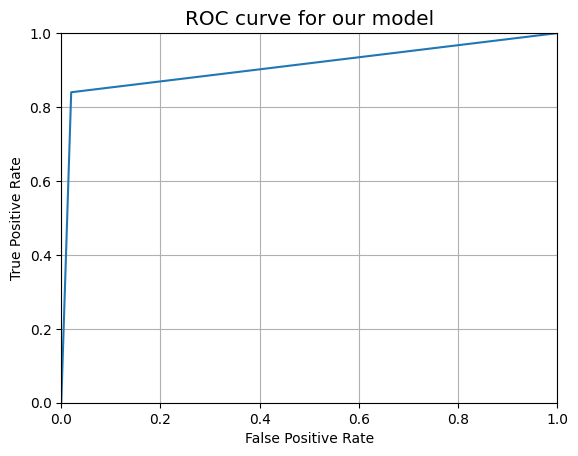

In [22]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
auc = roc_auc_score(y_test_bin, y_pred_bin)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('Inception_V3_ROC.png')
plt.grid(True)

Confusion Matrix without Normalization


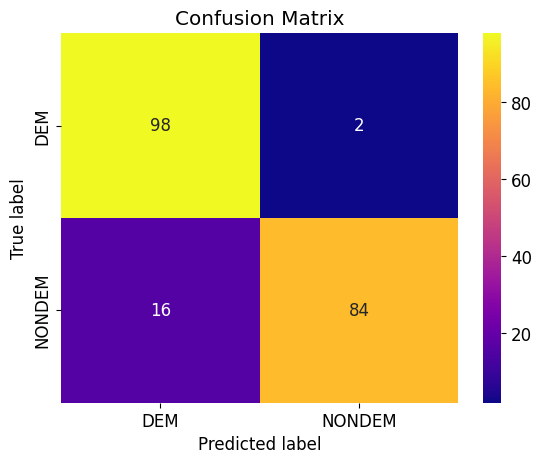

Confusion Matrix with Normalized Values


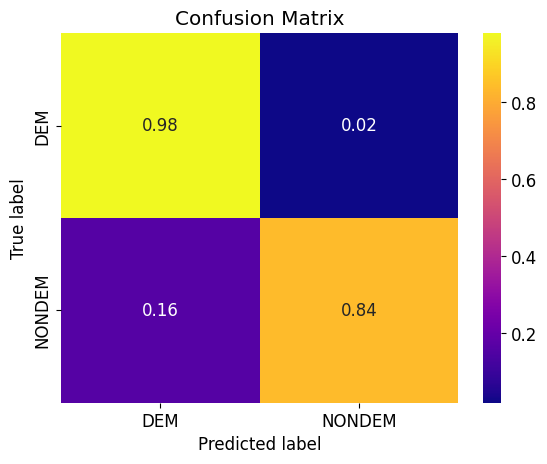

In [23]:
def plot_confusion_matrix(normalize):
  classes = ['DEM','NONDEM']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('Inception_V3_Confusion_Matrix.png')
  plt.show()
 
print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)
 
print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       100
           1       0.98      0.84      0.90       100

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.91      0.91       200



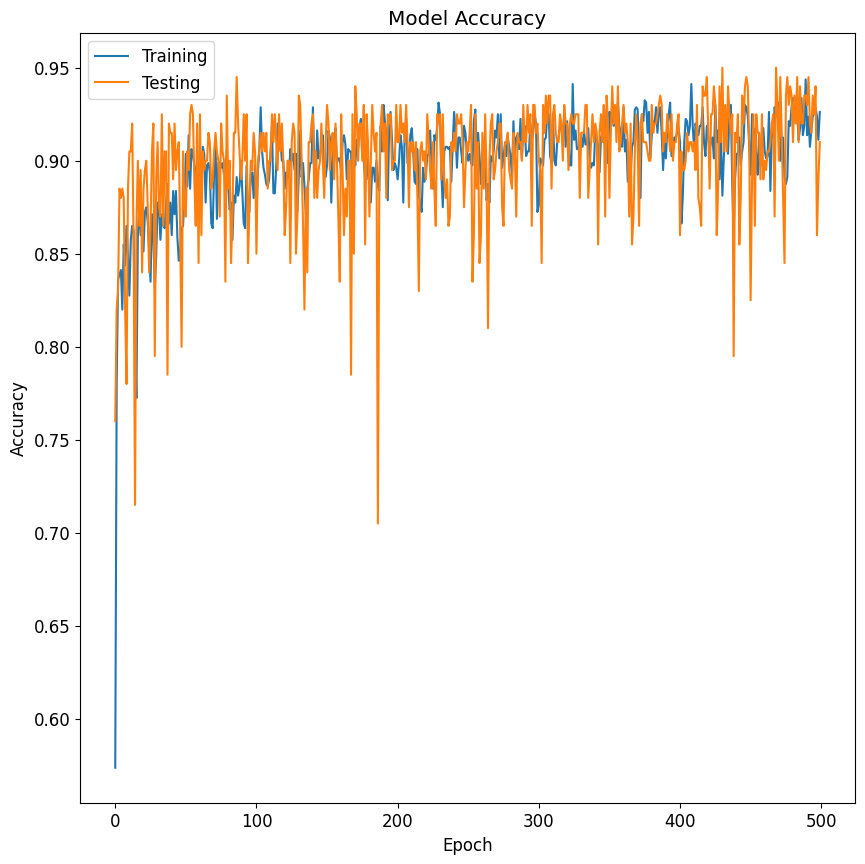

In [25]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig('Inception_V3_ct_accuracy.png')
plt.show()

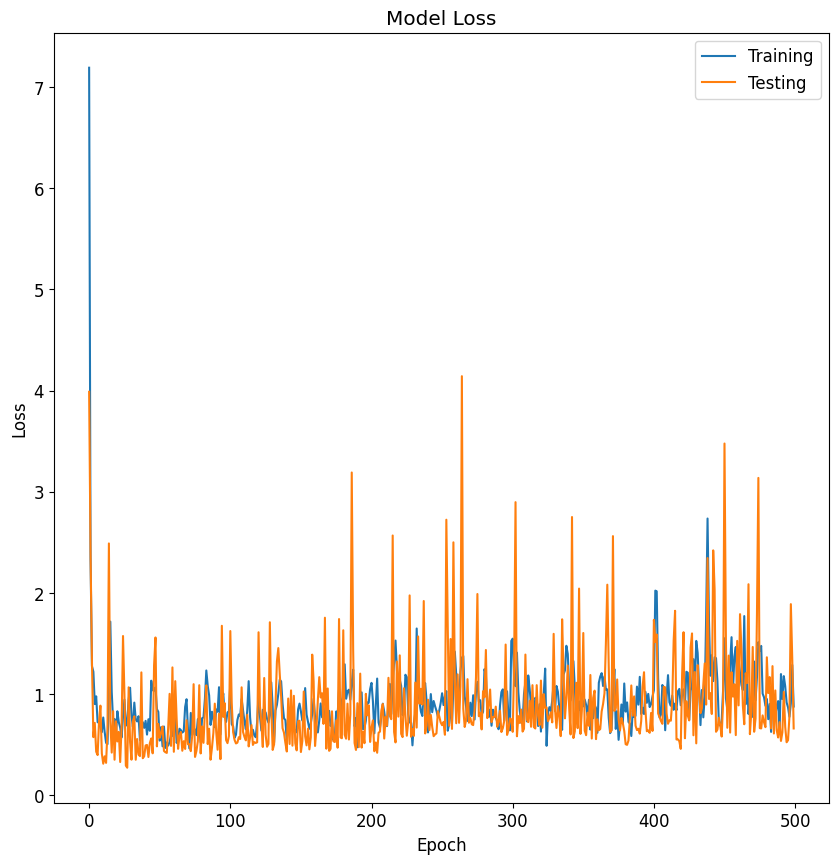

In [26]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
 
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig('Inception_V3_dem_loss.png')
plt.show()